
# Convolutional Neural Network - Fruit Classification


In [1]:
#########################################################################
# Import required packages
#########################################################################

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import os

In [3]:
#########################################################################
# Set Up flow For Training & Validation data
#########################################################################

In [4]:
# data flow parameters
training_data_dir = 'data/training'
validation_data_dir = 'data/validation'
batch_size= 32
image_width =128
image_height =128
num_channels = 3
num_classes =6 

In [5]:
# image generators (adding image augmentation only to training dataset)
training_generator = ImageDataGenerator(rescale = 1./255,
                                       rotation_range =20,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       zoom_range =0.2,
                                       horizontal_flip =True,
                                       brightness_range = (0.5, 1.5),
                                       fill_mode = 'nearest')

validation_generator = ImageDataGenerator(rescale = 1./255)

In [6]:
# image flows
training_set = training_generator.flow_from_directory(directory = training_data_dir,
                                                     target_size = (image_width, image_height),
                                                     batch_size = batch_size,
                                                     class_mode = 'categorical')
validation_set = validation_generator.flow_from_directory(directory = validation_data_dir,
                                                     target_size = (image_width, image_height),
                                                     batch_size = batch_size,
                                                     class_mode = 'categorical')
# class mode would be binary if we had only two classes of images

Found 360 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [7]:
#########################################################################
# Network Architecture
#########################################################################

In [21]:
# network architecture (hyperparameter Random Search to find the best model)
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters =hp.Int("input_conv_filters", min_value =32, max_value =256, step = 32),
                    kernel_size = (3,3),
                    padding = 'same',
                    input_shape = (image_width, image_height, num_channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    
    for i in range(hp.Int("n_Conv_Layers", min_value = 1, max_value = 5, step = 1)):
        model.add(Conv2D(filters =hp.Int(f"Conv{i}_filters", min_value =32, max_value =256, step = 32), kernel_size = (3,3),padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D())
        
    model.add(Flatten())

    for j in range(hp.Int("n_Dense_Layers",min_value =1, max_value =4, step = 1)):
        model.add(Dense(hp.Int(f"Dense_{j}_Neurons", min_value =32, max_value =256, step = 32)))
        model.add(Activation('relu'))
        
                               
        if hp.Boolean("Dropout"):
            model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss= 'categorical_crossentropy',
                 optimizer = hp.Choice ('optimizer', values = ['adam','RMSProp']),
                 metrics = ['accuracy'])
    return model

In [23]:
tuner = RandomSearch(hypermodel = build_model,
                    objective = 'val_accuracy',
                    max_trials = 5,
                    executions_per_trial = 5,
                    directory = os.path.normpath('C:/'),
                    project_name = 'fruit_CNN',
                    overwrite = True)

tuner.search(x = training_set, 
            validation_data = validation_set,
            epochs = 100,
            batch_size = 32)

Trial 5 Complete [04h 19m 26s]
val_accuracy: 0.6688888877630234

Best val_accuracy So Far: 0.997777771949768
Total elapsed time: 21h 12m 52s
INFO:tensorflow:Oracle triggered exit


In [26]:
### view artitecture
tuner.results_summary()

Results summary
Results in C:\fruit_CNN
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_conv_filters: 96
n_Conv_Layers: 3
Conv0_filters: 192
n_Dense_Layers: 1
Dense_0_Neurons: 192
Dropout: False
optimizer: adam
Conv1_filters: 160
Dense_1_Neurons: 96
Dense_2_Neurons: 64
Dense_3_Neurons: 96
Conv2_filters: 160
Score: 0.997777771949768
Trial summary
Hyperparameters:
input_conv_filters: 160
n_Conv_Layers: 3
Conv0_filters: 192
n_Dense_Layers: 2
Dense_0_Neurons: 192
Dropout: True
optimizer: RMSProp
Conv1_filters: 160
Dense_1_Neurons: 64
Dense_2_Neurons: 128
Dense_3_Neurons: 192
Conv2_filters: 32
Score: 0.9922222137451172
Trial summary
Hyperparameters:
input_conv_filters: 32
n_Conv_Layers: 2
Conv0_filters: 96
n_Dense_Layers: 4
Dense_0_Neurons: 64
Dropout: False
optimizer: RMSProp
Conv1_filters: 128
Dense_1_Neurons: 128
Dense_2_Neurons: 32
Dense_3_Neurons: 32
Score: 0.9899999976158143
Trial summary
Hyperparameters:
input_conv_filters: 

In [25]:
# best network
tuner.get_best_hyperparameters()[0].values

{'input_conv_filters': 96,
 'n_Conv_Layers': 3,
 'Conv0_filters': 192,
 'n_Dense_Layers': 1,
 'Dense_0_Neurons': 192,
 'Dropout': False,
 'optimizer': 'adam',
 'Conv1_filters': 160,
 'Dense_1_Neurons': 96,
 'Dense_2_Neurons': 64,
 'Dense_3_Neurons': 96,
 'Conv2_filters': 160}

In [28]:
## summary of best network
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 96)      2688      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 96)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 192)       166080    
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 192)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 160)       2

In [34]:
# network architecture
model = Sequential()
model.add(Conv2D(filters =96,
                kernel_size = (3,3),
                padding = 'same',
                input_shape = (image_width, image_height, num_channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D())



model.add(Conv2D(filters =192,
                kernel_size = (3,3),
                padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters =160,
                kernel_size = (3,3),
                padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters =160,
                kernel_size = (3,3),
                padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(192))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.compile(loss= 'categorical_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

In [35]:
#########################################################################
# Train Our Network!
#########################################################################

In [36]:
# training parameters
num_epochs = 100
model_filename = 'models/fruits_CNN_V05.h5'

In [37]:
# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                 monitor = 'val_accuracy',
                                 mode = 'max',
                                 verbose =1,
                                 save_best_only = True)

In [38]:
# train the network
history = model.fit(x = training_set,
                   validation_data = validation_set,
                   batch_size = batch_size,
                   epochs = num_epochs,
                   callbacks = [save_best_model])

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 2.0579 - accuracy: 0.1500
Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to models\fruits_CNN_V05.h5
12/12 [==============================] - 30s 3s/step - loss: 2.0579 - accuracy: 0.1500 - val_loss: 1.7903 - val_accuracy: 0.1667
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 1.7964 - accuracy: 0.1583
Epoch 00002: val_accuracy improved from 0.16667 to 0.27222, saving model to models\fruits_CNN_V05.h5
12/12 [==============================] - 29s 2s/step - loss: 1.7964 - accuracy: 0.1583 - val_loss: 1.7898 - val_accuracy: 0.2722
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 1.7902 - accuracy: 0.1556
Epoch 00003: val_accuracy did not improve from 0.27222
12/12 [==============================] - 28s 2s/step - loss: 1.7902 - accuracy: 0.1556 - val_loss: 1.7793 - val_accuracy: 0.1667
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 1.758

Epoch 28/100
12/12 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.8111
Epoch 00028: val_accuracy did not improve from 0.94444
12/12 [==============================] - 24s 2s/step - loss: 0.5428 - accuracy: 0.8111 - val_loss: 0.7088 - val_accuracy: 0.7056
Epoch 29/100
12/12 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8139
Epoch 00029: val_accuracy did not improve from 0.94444
12/12 [==============================] - 24s 2s/step - loss: 0.4597 - accuracy: 0.8139 - val_loss: 0.2972 - val_accuracy: 0.8667
Epoch 30/100
12/12 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8667
Epoch 00030: val_accuracy did not improve from 0.94444
12/12 [==============================] - 23s 2s/step - loss: 0.3903 - accuracy: 0.8667 - val_loss: 0.2251 - val_accuracy: 0.9333
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8722
Epoch 00031: val_accuracy did not improve from 0.94444
12/12 [==

Epoch 57/100
12/12 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.9056
Epoch 00057: val_accuracy did not improve from 0.98889
12/12 [==============================] - 22s 2s/step - loss: 0.3144 - accuracy: 0.9056 - val_loss: 0.2557 - val_accuracy: 0.9056
Epoch 58/100
12/12 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9389
Epoch 00058: val_accuracy did not improve from 0.98889
12/12 [==============================] - 24s 2s/step - loss: 0.1989 - accuracy: 0.9389 - val_loss: 0.1039 - val_accuracy: 0.9611
Epoch 59/100
12/12 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.9472
Epoch 00059: val_accuracy did not improve from 0.98889
12/12 [==============================] - 25s 2s/step - loss: 0.1765 - accuracy: 0.9472 - val_loss: 0.0987 - val_accuracy: 0.9667
Epoch 60/100
12/12 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9500
Epoch 00060: val_accuracy did not improve from 0.98889
12/12 [==

In [15]:
#########################################################################
# Visualise Training & Validation Performance
#########################################################################

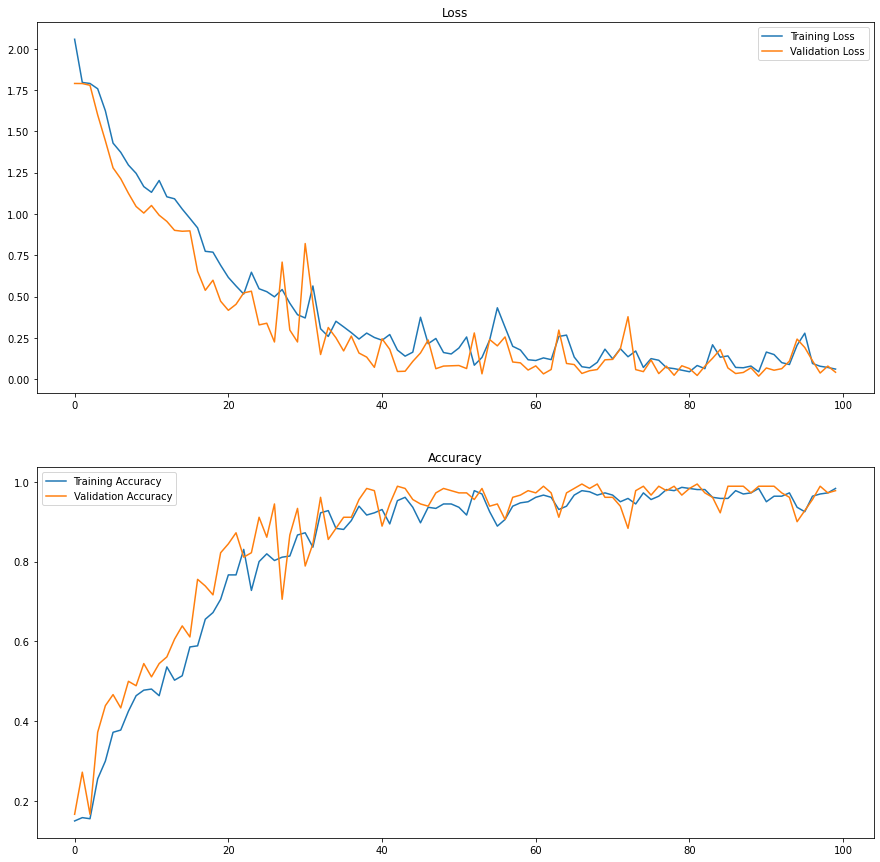

In [39]:
import matplotlib.pyplot as plt

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

In [40]:
# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])

0.9944444298744202

In [41]:
#########################################################################
# Make Predictions On New Data (Test Set)
#########################################################################

In [42]:
# import required packages
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd
from os import listdir



In [43]:
# parameters for prediction
model_filename = 'models/fruits_CNN_V05.h5'
image_width =128
image_height =128
labels_list = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange']


In [44]:
# load model
model = load_model(model_filename)

In [46]:
# image pre-processing function

def preprocess_image(filepath):
    image =load_img(filepath,target_size = (image_width,image_height))

    image = img_to_array(image)
    image = np.expand_dims(image, axis =0)
    image = image * (1./255)
    
    return image

# image prediction function

def make_prediction(image):
    class_probs = model.predict(image)
    predicted_class = np.argmax(class_probs)

    predicted_label =labels_list[predicted_class]
    predicted_prob = class_probs[0][predicted_class]
    
    return predicted_label, predicted_prob


In [47]:
# loop through test data

source_dir ='data/test/'
folder_names =  ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange']
actual_labels = []
predicted_labels = []
predicted_probabilities = []
filenames =[]

for folder in folder_names:
    
    images = listdir(source_dir + '/' + folder)
    
    for image in images:
        
        processed_image = preprocess_image(source_dir + '/'+ folder + '/' + image)
        predicted_label, predicted_probability = make_prediction(processed_image)
        
        actual_labels.append(folder)
        predicted_labels.append(predicted_label)
        predicted_probabilities.append(predicted_probability)
        filenames.append(image)

In [48]:
# create dataframe to analyse
prediction_df = pd.DataFrame({"actual_label": actual_labels,
                             "predicted_label": predicted_labels,
                             "predicted_probability": predicted_probabilities,
                             "filename": filenames})

In [49]:
prediction_df['correct'] = np.where(prediction_df['actual_label']== prediction_df['predicted_label'], 1, 0)
prediction_df

,actual_label,predicted_label,predicted_probability,filename,correct
0,apple,apple,1.000000,apple_0004.jpg,1
1,apple,apple,1.000000,apple_0014.jpg,1
2,apple,apple,1.000000,apple_0024.jpg,1
3,apple,apple,1.000000,apple_0034.jpg,1
4,apple,apple,1.000000,apple_0044.jpg,1
5,apple,apple,1.000000,apple_0054.jpg,1
6,apple,apple,1.000000,apple_0064.jpg,1
7,apple,apple,1.000000,apple_0074.jpg,1
8,apple,apple,1.000000,apple_0084.jpg,1
9,apple,apple,0.750646,apple_0094.jpg,1


In [50]:
# overall test set accuracy

test_set_accuracy = prediction_df['correct'].sum() / len(prediction_df)
print(test_set_accuracy)
## 68 % basic
## 0.88 % dropout
## 93 % augmentation & dropout
## hp 100 % accuracy

1.0


In [51]:
# confusion matrix
confusion_matrix =pd.crosstab(prediction_df['predicted_label'], prediction_df['actual_label'])
confusion_matrix

actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,10,0,0,0,0,0
avocado,0,10,0,0,0,0
banana,0,0,10,0,0,0
kiwi,0,0,0,10,0,0
lemon,0,0,0,0,10,0
orange,0,0,0,0,0,10


In [52]:
### percentage (conf_matrix)
confusion_matrix =pd.crosstab(prediction_df['predicted_label'], prediction_df['actual_label'], normalize = 'columns')
confusion_matrix

actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,1.0,0.0,0.0,0.0,0.0,0.0
avocado,0.0,1.0,0.0,0.0,0.0,0.0
banana,0.0,0.0,1.0,0.0,0.0,0.0
kiwi,0.0,0.0,0.0,1.0,0.0,0.0
lemon,0.0,0.0,0.0,0.0,1.0,0.0
orange,0.0,0.0,0.0,0.0,0.0,1.0
